# Adaptive Multilook

In this tutorial, we demostrate how to use decorrelation package to identify spatially homogeneous pixels, extimate the coherence matrix and compare the original interferogram, multilook intergerogram and the adaptive multilook interferogram.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import h5py

import cupy as cp
from cupyx.scipy.ndimage import median_filter

from decorrelation.shp import ks_test
from decorrelation.plot import bg_alpha
from decorrelation.co import emperical_co

## Load rslc stack

In [ ]:
cp.cuda.Device(1).use()

<CUDA Device 1>

In [ ]:
rslc = cp.load('../../data/rslc.npy')
rslc.shape

(2500, 1834, 17)

## Apply ks test

In [ ]:
rmli = cp.abs(rslc)**2

In [ ]:
az_half_win = 5
r_half_win = 5
az_win = 2*az_half_win+1
r_win = 2*r_half_win+1

In [ ]:
%%time
p = ks_test(rmli,az_half_win=az_half_win,r_half_win=r_half_win)[1]

CPU times: user 45.7 ms, sys: 28.6 ms, total: 74.3 ms
Wall time: 74.8 ms


`ks_test` in decorrelation package is extremely fast!

## Select SHPs

In [ ]:
is_shp = (p < 0.05) & (p >= 0.0)

In [ ]:
shp_num = cp.count_nonzero(is_shp,axis=(-2,-1))
shp_num_np = cp.asnumpy(shp_num)

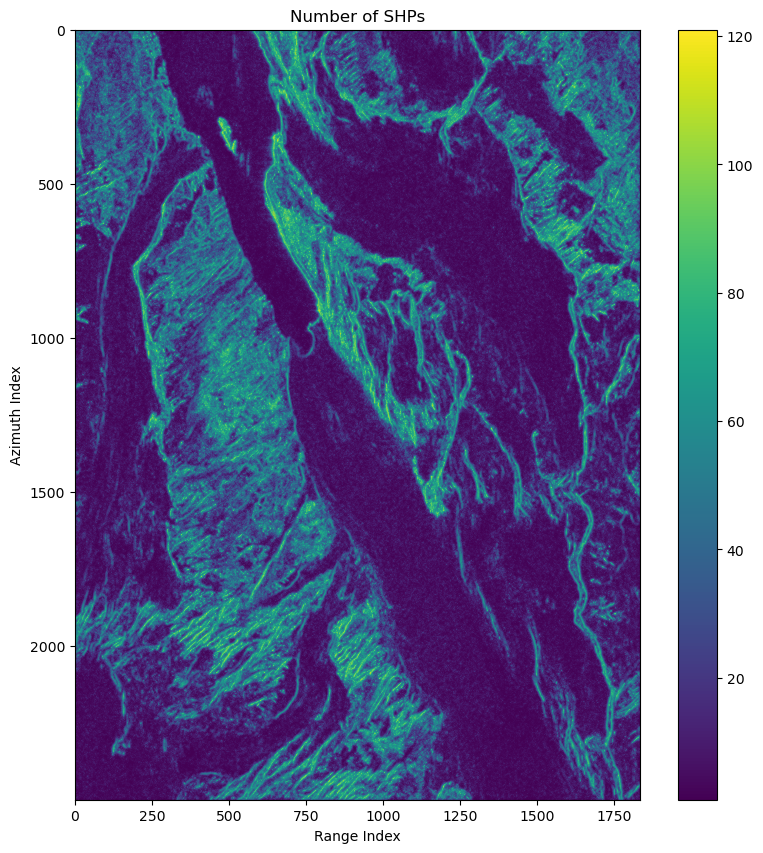

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(shp_num_np)
ax.set(title='Number of SHPs',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

## Estimate coherence matrix

In [ ]:
%%time
coh = emperical_co(rslc,is_shp)[1]

CPU times: user 226 ms, sys: 18.8 ms, total: 245 ms
Wall time: 253 ms


## Compare

Here we compare 1-look interferogram, multilook interferogram and adaptive multilook interferogram

In [ ]:
ref_image = 15
sec_image = 16

1 look interferogram:

In [ ]:
diff = rslc[:,:,ref_image]*rslc[:,:,sec_image].conj()

Multilook interferogram:

In [ ]:
ml_diff = median_filter(diff,size=(az_win,r_win))

Adaptive multilook interferogram:

In [ ]:
ad_ml_diff = coh[:,:,ref_image,sec_image]

The plot background:

In [ ]:
plot_bg = rmli[:,:,0]
plot_bg = cp.asnumpy(plot_bg)
alpha = bg_alpha(plot_bg)

Plot:

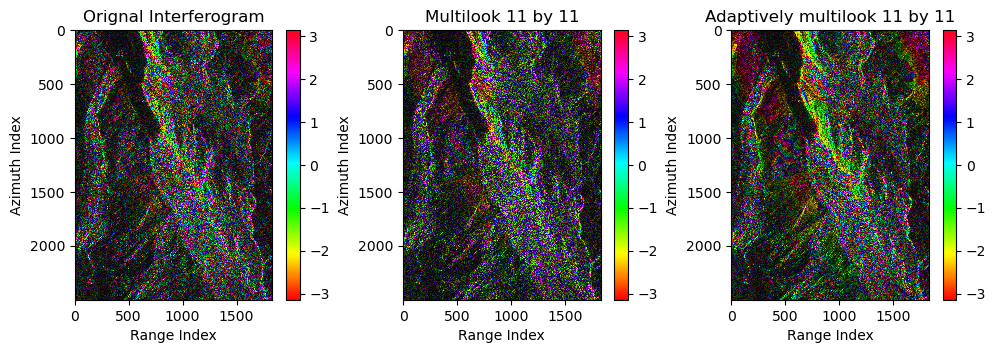

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(24/2,7/2))
xlabel = 'Range Index'
ylabel = 'Azimuth Index'
pcm0 = axes[0].imshow(cp.asnumpy(cp.angle(diff)),alpha=alpha,interpolation='nearest',cmap='hsv')
pcm1 = axes[1].imshow(cp.asnumpy(cp.angle(ml_diff)),alpha=alpha,interpolation='nearest',cmap='hsv')
pcm2 = axes[2].imshow(cp.asnumpy(cp.angle(ad_ml_diff)),alpha=alpha,interpolation='nearest',cmap='hsv')
for ax in axes:
    ax.set(facecolor = "black")
axes[0].set(title='Orignal Interferogram',xlabel=xlabel,ylabel=ylabel)
axes[1].set(title=f'Multilook {az_win} by {r_win}',xlabel=xlabel,ylabel=ylabel)
axes[2].set(title=f'Adaptively multilook {az_win} by {r_win}',xlabel=xlabel,ylabel=ylabel)
fig.colorbar(pcm0,ax=axes[0])
fig.colorbar(pcm1,ax=axes[1])
fig.colorbar(pcm1,ax=axes[2])
fig.show()

## Conclusion

- Adaptive multilooking based on SHPs selection performs better than non-adaptive one;
- `ks_test` and `emperical_co` implemented in `decorrelation` package are fast.